# Qunatitative study on the induction of mRNA and its stability

Author: Anna B. Matuszyńska <a href="https://orcid.org/0000-0003-0882-6088"><img src="https://orcid.org/assets/vectors/orcid.logo.icon.svg" width=15></a>

In this notebook we explore the ideas presented in the original work by Hargrove and Schmidt [1] and White, Brewer and Wilson [2] on the effect that changing the rate of synthesis and degradation of mRNA would have on the final concentration. We play with the simplest, well established mathematical model based on a single compartment, with zero-order rate kinetics for mRNA synthesis and first-order rate of decay. 

This notebook aims at further supporting hypotheses generated by **Srimeenakshi Sankaranarayanan**, Carl Haag, Patrick Petzsch, Karl Köhrer, Kathi Zarnack and **Michael Feldbrügge** in their manuscript.

[1] Hargrove,J.L.; Schmidt, F. H. [The role of mRNA and protein stability in gene expression.](https://faseb.onlinelibrary.wiley.com/doi/10.1096/fasebj.3.12.2676679) *FASEB J*. 3: 2360-2370; 1989.

[2] White, E.J.F.; Brewer, G.; Wilson, G.M. [Post-transcriptional control of gene expression by AUF1:
Mechanisms, physiological targets, and regulation.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3664190/) *Biochim Biophys Acta.* 1829(0): 680–688; 2013.

In [43]:
%matplotlib inline

import numpy as np
import pandas

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from modelbase.ode import Model, Simulator, mca
from modelbase.ode import ratelaws as rl

mRNA concentrations can be modified by altering synthesis and/or degradation rates

\begin{equation}
\frac{d\mathrm{[mRNA]}}{dt} = v_\mathrm{synthesis} - v_\mathrm{degradation}
\end{equation}

\begin{equation}
v_\mathrm{synthesis} = k_\mathrm{synthesis}
\end{equation}

\begin{equation}
v_\mathrm{degradation} = k_\mathrm{decay} \cdot \text{[mRNA]}
\end{equation}

From [2] we assume that the rate of mRNA decay is inversly related to the mRNA half-life $(t_{1/2})$.


\begin{equation}
t_{1/2} = \frac{ln 2}{k_\mathrm{decay}}
\end{equation}

hence the longer half-time translates to slower rate of mRNA decay.

This behaviour can be observed by simulating change in the mRNA concentration over time with various half times at the same rate of mRNA synthesis for two strains: *Mob1* and *Arl1*.


- *Mob1*: half-life 8 minutes, initial concentration 36, steady state 308,
- *Arl1*: half-life 16 minutes, initial concentration 52, steady stated 165.

In [193]:
def decay(halftime):
    """ return the rate of mRNA decay for the given half-life"""
    return np.log(2)/halftime

### Define model

In [194]:
m = Model()

m.add_compounds(["mRNA"])
m.add_parameters({'kSynth': 1, 'kDecay': decay(0.0578)})

def constant(k):
    return k

def mass_action_1s(s, kp):
    """Irreversible mass-action function with 1 substrate
    Arguments:
    s -> Substrate
    kp -> positive rate constant 
    """
    return kp * s

m.add_reaction_from_args(
    rate_name = "vSynth", #This should be a unique name that helps you identify the appropriate reaction
    function = constant, #This is the appropriate function you created beforehand
    stoichiometry = {"mRNA": 1}, #This is a dictionary of the compounds with their respective stochiometry in this specific reaction
    args = ["kSynth"] #this is a list of all arguments passed to the function, in their respective oder
)

m.add_reaction_from_args(
    rate_name = "vDecay",
    function = mass_action_1s,
    stoichiometry = {"mRNA": -1},
    args = ["mRNA", "kDecay"],
    reversible = False
)

## Effect of the half/time on the mRNA concentration over time

Assuming the same rate of mRNA synthesis but 10 fold-different rate of degradation we simulate the induction of mRNA and mark the halftime of reaching the steady-state. This simulation reproduces the original Figure 2 from [1].

Text(0.5, 1.0, 'Induction of mRNA for the same synthesis and 10-fold increased rate of decay')

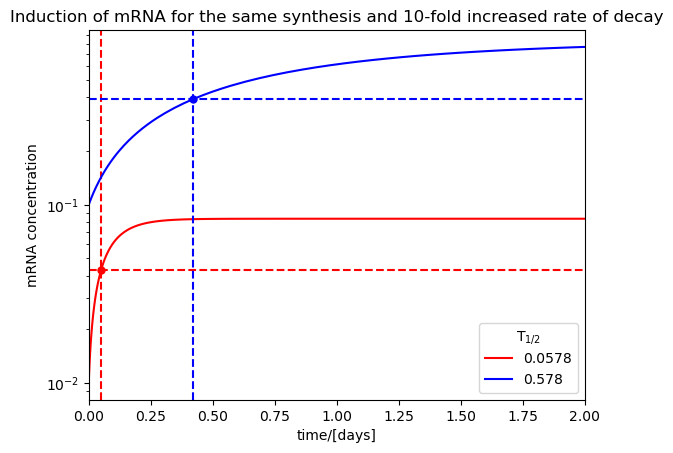

In [262]:
colors = ['r', 'b']

for i,j,k in zip([0.1,1.],colors,[0.0578, 0.578]):
    s = Simulator(m)
    y0 = {'mRNA': 0.1*i}
    s.update_parameters({'kSynth': 1., 'kDecay': decay(k)})
    s.initialise(y0)
    t, y = s.simulate(2) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                            #and the different concentrations in a nested array
  
    plt.plot(t,y, label = str(k), color=j)
    plt.xlabel("time/[days]")
    
    #print(y[np.where(y <= 0.5 * y[-1])])
    
    findhalf = min([i for i in range(len(y)) if y[i] >= 0.5 * y[-1]])
    
    plt.plot(t[findhalf], 
             y[findhalf], marker='o', color=j, markersize=5)
    
    plt.axhline(y=y[findhalf], xmin=0, xmax=1, color=j, linestyle = "--")
    plt.axvline(x=t[findhalf], color=j, linestyle = "--")
    
# Setting the Y-axis scale to logarithmic
plt.yscale('log')
plt.ylabel('mRNA concentration')
plt.xlim(0,2)
plt.legend(title="T$_{1/2}$")
plt.title("Induction of mRNA for the same synthesis and 10-fold increased rate of decay")

If we now repeat the experiment, but instead of changing the half-time we will increase 10 fold rate of synthesis we observe that the change does not affect the time of reaching half of the steady state concentration for the given parameters set and the starting concentration of mRNA.

Text(0.5, 1.0, 'Induction of mRNA for the same synthesis and 10-fold increased decay')

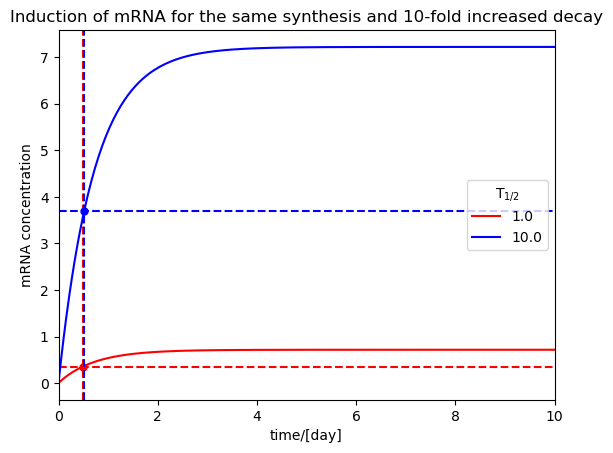

In [256]:
for i,j in zip([1.,10.],colors):
    s = Simulator(m)
    y0 = {'mRNA': 0.01}
    s.update_parameters({'kSynth': i, 'kDecay': decay(0.5)})
    s.initialise(y0)
    t, y = s.simulate(10) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                            #and the different concentrations in a nested array
    
    plt.plot(t,y, label = str(i), color=j)
    plt.ylabel("mRNA concentration")
    plt.xlabel("time/[day]")
    
    #print(y[np.where(y <= 0.5 * y[-1])])
    
    findhalf = min([hl for hl in range(len(y)) if y[hl] >= 0.5 * y[-1]])
    
    plt.plot(t[findhalf], 
             y[findhalf], marker='o', color=j, markersize=5)
    
    plt.axhline(y=y[findhalf], xmin=0, xmax=1, color=j, linestyle = "--")
    plt.axvline(x=t[findhalf], color=j, linestyle = "--")

    
plt.xlim(0,10)
plt.legend(title="T$_{1/2}$")
plt.title("Induction of mRNA for the same synthesis and 10-fold increased decay")

## Comparative analysis of *Mob1* in wildtype and *khd4*$\Delta$
rate of synthesis kept the same, half time two times longer for the mutant

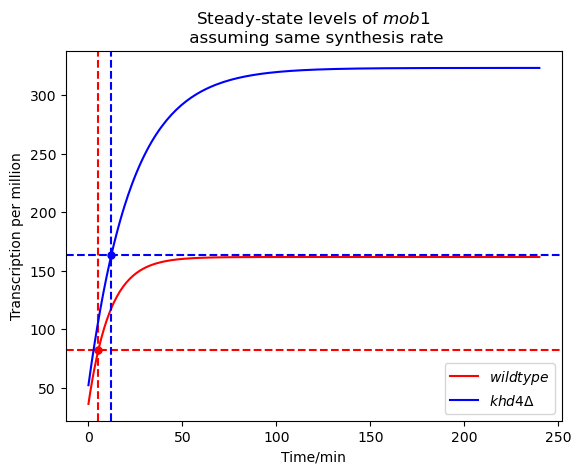

In [280]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i,j,k, l in zip([36.,52.],colors, ['$wildtype$','$\it{khd4}\Delta$'], [8, 16]):
    s_mob1 = Simulator(m)
    y0 = {'mRNA': i}
    m.update_parameters({'kSynth': 14, 'kDecay': decay(l)})
    s_mob1.initialise(y0)
    t, y = s_mob1.simulate(4*60) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                    #and the different concentrations in a nested array
    ax.plot(s_mob1.get_time(), s_mob1.get_variable('mRNA'), label = k, color=j)
    findhalf = min([hl for hl in range(len(y)) if y[hl] >= 0.5 * y[-1]])

    plt.plot(t[findhalf], 
             y[findhalf], marker='o', color=j, markersize=5)

    plt.axhline(y=y[findhalf], xmin=0, xmax=1, color=j, linestyle = "--")
    plt.axvline(x=t[findhalf], color=j, linestyle = "--")

plt.xlabel("Time/min")
plt.ylabel("Transcription per million") #modelbase gives us the option to plot immediately through our Simulator() object,
                                                                        #but we could have also done it with the t and y variables appointed earlier.
plt.title('Steady-state levels of $\it{mob1}$ \n assuming same synthesis rate')
ax.legend()        

rate of synthesis two times faster for the mutant, half time kept the same

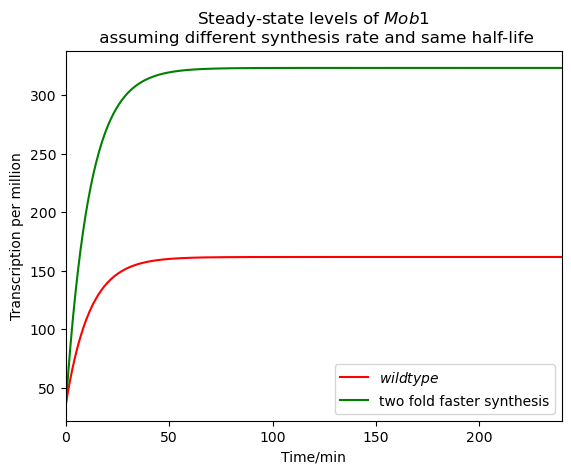

In [281]:
fig = plt.figure()
ax = fig.add_subplot(111)

synthesis = 14
s_mob1 = Simulator(m)
y0 = {'mRNA': 36}
m.update_parameters({'kSynth': synthesis, 'kDecay': decay(8)})
s_mob1.initialise(y0)
t, y = s_mob1.simulate(4*60) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                #and the different concentrations in a nested array
ax.plot(s_mob1.get_time(), s_mob1.get_variable('mRNA'), label = '$wildtype$')


s_arl1 = Simulator(m)
y0 = {'mRNA': 36}
m.update_parameters({'kSynth': 2*synthesis, 'kDecay': decay(8)})
s_arl1.initialise(y0)
t, y = s_arl1.simulate(4*60) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                #and the different concentrations in a nested array
ax.plot(s_arl1.get_time(), s_arl1.get_variable('mRNA'), label = 'two fold faster synthesis')

plt.xlim(0, 240)
plt.xlabel("Time/min")
plt.ylabel("Transcription per million") #modelbase gives us the option to plot immediately through our Simulator() object,
                                                                        #but we could have also done it with the t and y variables appointed earlier.
plt.title('Steady-state levels of $\it{Mob1}$ \n assuming different synthesis rate and same half-life')
ax.legend()        